In [2]:
import graph_fourier_transform
import graph_ruggedness_de
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import networkx as nx
import os
import matplotlib.ticker as ticker
import matplotlib.colors as colors
import matplotlib.cm as cm
from scipy.stats import spearmanr
import brownian_motion

## Ruggedness across different fitness functions
Figure 5 is focussed on how rugged different fitness functions over the same sequences. For example, it may be hypothesized that thermostability is a less rugged trait than Kcat, as thermostability is distributed over the protein sequence and can be accomodated by compensatory mutations, whereas Kcat will be restricted predominantly to the active site / functional sites and may not necessarily be accomodated by compensatory mutations. PafA is an ideal system to investigate this over, as the experimental assat reports Kcat, Km and a series of other traits over a distribution of mutations. 

In [27]:
df

,Unnamed: 0,variant,library,kcat_cMUP_s-1,kcat_cMUP_limit,kcat_cMUP_p-value,KM_cMUP_uM,KM_cMUP_limit,KM_cMUP_p-value,kcatOverKM_cMUP_M-1s-1,...,FC1,FC1_limit,FC1_p-value,FC2/3,FC2/3_limit,FC2/3_p-value,FC4_s-1,FC4_limit,FC4_p-value,sequence
0,0,Q21G,Glycine,220.0,none,0.0006,90.0,none,0.690,2000000.0,...,0.95,none,0.74,1.00,none,0.380,190.0,none,0.34,MLTPKKWLLGVLVVSGMLGAGKTNAVPRPKLVVGLVVDQMRWDYLY...
1,1,Q21V,Valine,210.0,none,0.0001,92.0,none,0.440,2200000.0,...,1.70,none,0.11,1.10,none,0.200,160.0,none,0.61,MLTPKKWLLGVLVVSGMLGAVKTNAVPRPKLVVGLVVDQMRWDYLY...
2,2,K22G,Glycine,74.0,none,0.0990,69.0,none,0.230,1600000.0,...,0.97,none,0.90,0.87,none,0.014,72.0,none,0.26,MLTPKKWLLGVLVVSGMLGAQGTNAVPRPKLVVGLVVDQMRWDYLY...
3,3,K22V,Valine,130.0,none,0.7600,100.0,none,0.094,1200000.0,...,1.40,none,0.26,1.20,none,0.016,180.0,none,0.30,MLTPKKWLLGVLVVSGMLGAQVTNAVPRPKLVVGLVVDQMRWDYLY...
4,4,T23G,Glycine,110.0,none,0.5000,77.0,none,0.410,1400000.0,...,1.10,none,0.75,1.00,none,0.510,130.0,none,0.73,MLTPKKWLLGVLVVSGMLGAQKGNAVPRPKLVVGLVVDQMRWDYLY...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1036,1036,G545A,Glycine,120.0,none,0.9600,75.0,none,0.380,2200000.0,...,1.50,none,0.12,0.92,none,0.200,87.0,none,0.29,MLTPKKWLLGVLVVSGMLGAQKTNAVPRPKLVVGLVVDQMRWDYLY...
1037,1037,G545V,Valine,200.0,none,0.0000,92.0,none,0.400,2000000.0,...,0.86,none,0.72,1.10,none,0.250,160.0,none,0.56,MLTPKKWLLGVLVVSGMLGAQKTNAVPRPKLVVGLVVDQMRWDYLY...
1038,1038,R546G,Glycine,170.0,none,0.0430,81.0,none,0.740,1900000.0,...,1.20,none,0.64,0.97,none,0.350,150.0,none,0.89,MLTPKKWLLGVLVVSGMLGAQKTNAVPRPKLVVGLVVDQMRWDYLY...
1039,1039,R546V,Valine,120.0,none,0.8800,96.0,none,0.280,1300000.0,...,0.86,none,0.67,1.00,none,0.430,150.0,none,0.84,MLTPKKWLLGVLVVSGMLGAQKTNAVPRPKLVVGLVVDQMRWDYLY...


In [28]:
df = pd.read_csv('../data_files/pafa_kinase//PafA_all_data.csv')
df = df.dropna()
seq_ls = df['sequence'].tolist()
values = df['KM_cMUP_uM'].tolist()
scaler = MinMaxScaler()
values = [val[0] for val in (scaler.fit_transform(np.array(values).reshape(-1,1)))]

G_k_km = graph_ruggedness_de.build_ohe_graph(seq_ls=seq_ls,
                                        values=values,
                                        edges=True,
                                        hamming_edges=False, 
                                        approximate=True,
                                        n=1)

values = df['kcat_cMUP_s-1'].tolist()
scaler = MinMaxScaler()
values = [val[0] for val in (scaler.fit_transform(np.array(values).reshape(-1,1)))]

G_k_kcat = graph_ruggedness_de.build_ohe_graph(seq_ls=seq_ls,
                                        values=values,
                                        edges=True,
                                        hamming_edges=False, 
                                        approximate=True,
                                        n=1)

values = df['kcatOverKM_cMUP_M-1s-1'].tolist()
scaler = MinMaxScaler()
values = [val[0] for val in (scaler.fit_transform(np.array(values).reshape(-1,1)))]
G_k_kcat_km = graph_ruggedness_de.build_ohe_graph(seq_ls=seq_ls,
                                        values=values,
                                        edges=True,
                                        hamming_edges=False, 
                                        approximate=True,
                                        n=1)

values = df['fa'].tolist()
scaler = MinMaxScaler()
values = [val[0] for val in (scaler.fit_transform(np.array(values).reshape(-1,1)))]

G_k_fa = graph_ruggedness_de.build_ohe_graph(seq_ls=seq_ls,
                                        values=values,
                                        edges=True,
                                        hamming_edges=False, 
                                        approximate=True,
                                        n=1)

Computing OHE dictionary.: 20it [00:00, 139114.56it/s]
Adding nodes to graph.: 0it [00:00, ?it/s]

Adding nodes to graph.: 851it [00:00, 9555.45it/s]


Building approx. NN index.
Done.


Adding OHE vectors to index.: 851it [00:00, 1865.10it/s]


Building approx. NN search tree(s).
Done.


Adding approximate KNN edges.: 851it [00:00, 33456.30it/s]
Computing OHE dictionary.: 20it [00:00, 103180.91it/s]
Adding nodes to graph.: 851it [00:00, 11044.06it/s]


Building approx. NN index.
Done.


Adding OHE vectors to index.: 851it [00:00, 1830.25it/s]


Building approx. NN search tree(s).
Done.


Adding approximate KNN edges.: 851it [00:00, 32468.44it/s]
Computing OHE dictionary.: 20it [00:00, 108100.62it/s]
Adding nodes to graph.: 851it [00:00, 10882.77it/s]


Building approx. NN index.
Done.


Adding OHE vectors to index.: 851it [00:00, 1832.23it/s]


Building approx. NN search tree(s).
Done.


Adding approximate KNN edges.: 851it [00:00, 32090.13it/s]
Computing OHE dictionary.: 20it [00:00, 125016.51it/s]
Adding nodes to graph.: 851it [00:00, 10802.64it/s]


Building approx. NN index.
Done.


Adding OHE vectors to index.: 851it [00:00, 1848.84it/s]


Building approx. NN search tree(s).
Done.


Adding approximate KNN edges.: 851it [00:00, 31426.72it/s]


/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_24796/3466742063.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = plt.cm.get_cmap('viridis', 10)
/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_24796/3466742063.py:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


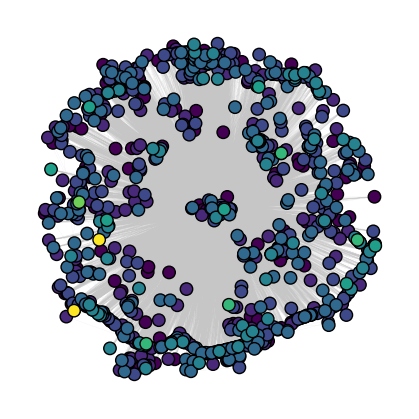

In [29]:
values = [node[1]['value'] for node in G_k_kcat_km.nodes(data=True)]
viridis = plt.cm.get_cmap('viridis', 10)
pos = nx.spring_layout(G_k_kcat_km, k=0.009)


fig = plt.figure(figsize=(4, 4))
nodes_sorted_by_value = sorted(G_k_kcat_km.nodes(data=True), key=lambda x: x[1]['value'])
node_colors = [viridis((node[1]['value'] - min(values)) / (max(values) - min(values))) for node in nodes_sorted_by_value]
nodes_sorted = [node[0] for node in nodes_sorted_by_value]

plt.tight_layout()
nx.draw(G_k_kcat_km, pos, nodelist=nodes_sorted, node_color=node_colors, with_labels=False, edgecolors='black', node_size=80, width=0.05, edge_color='#C6C6C6')
plt.tight_layout()
plt.savefig('figures/Figure_5/kcat_km_graph.pdf')
plt.show()

/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_24796/3320157755.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = plt.cm.get_cmap('viridis', 10)
/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_24796/3320157755.py:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


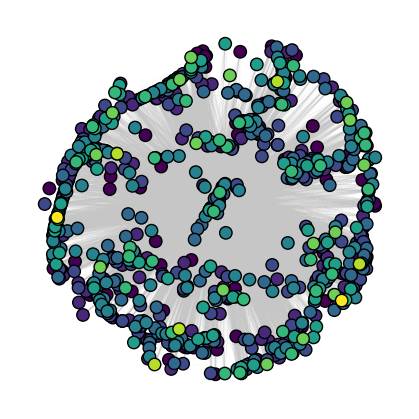

In [30]:
values = [node[1]['value'] for node in G_k_kcat.nodes(data=True)]
viridis = plt.cm.get_cmap('viridis', 10)
pos = nx.spring_layout(G_k_kcat, k=0.009)


fig = plt.figure(figsize=(4, 4))
nodes_sorted_by_value = sorted(G_k_kcat.nodes(data=True), key=lambda x: x[1]['value'])
node_colors = [viridis((node[1]['value'] - min(values)) / (max(values) - min(values))) for node in nodes_sorted_by_value]
nodes_sorted = [node[0] for node in nodes_sorted_by_value]

plt.tight_layout()
nx.draw(G_k_kcat, pos, nodelist=nodes_sorted, node_color=node_colors, with_labels=False, edgecolors='black', node_size=80, width=0.05, edge_color='#C6C6C6')
plt.tight_layout()
plt.savefig('figures/Figure_5/kcat_graph.pdf')
plt.show()

/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_24796/375399137.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = plt.cm.get_cmap('viridis', 10)
/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_24796/375399137.py:12: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


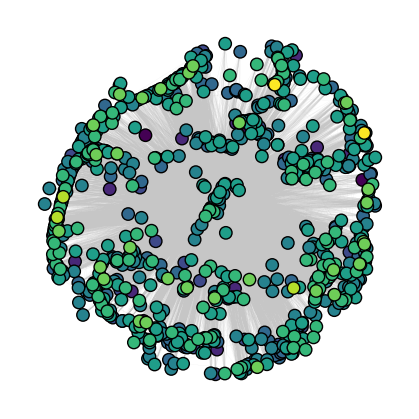

In [31]:
values = [node[1]['value'] for node in G_k_km.nodes(data=True)]
viridis = plt.cm.get_cmap('viridis', 10)


fig = plt.figure(figsize=(4, 4))
nodes_sorted_by_value = sorted(G_k_km.nodes(data=True), key=lambda x: x[1]['value'])
node_colors = [viridis((node[1]['value'] - min(values)) / (max(values) - min(values))) for node in nodes_sorted_by_value]
nodes_sorted = [node[0] for node in nodes_sorted_by_value]

plt.tight_layout()
nx.draw(G_k_km, pos, nodelist=nodes_sorted, node_color=node_colors, with_labels=False, edgecolors='black', node_size=80, width=0.05, edge_color='#C6C6C6')
plt.tight_layout()
plt.savefig('figures/Figure_5/km_graph.pdf')
plt.show()

/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_24796/3738028987.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = plt.cm.get_cmap('viridis', 10)
/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_24796/3738028987.py:11: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


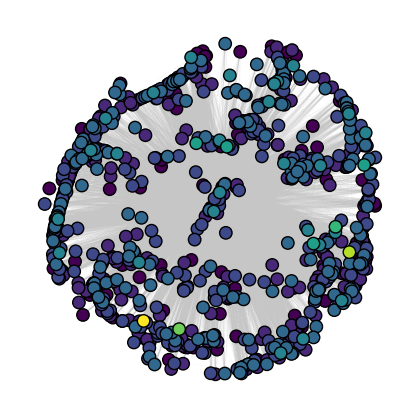

In [32]:
values = [node[1]['value'] for node in G_k_fa.nodes(data=True)]
viridis = plt.cm.get_cmap('viridis', 10)

fig = plt.figure(figsize=(4, 4))
nodes_sorted_by_value = sorted(G_k_fa.nodes(data=True), key=lambda x: x[1]['value'])
node_colors = [viridis((node[1]['value'] - min(values)) / (max(values) - min(values))) for node in nodes_sorted_by_value]
nodes_sorted = [node[0] for node in nodes_sorted_by_value]

plt.tight_layout()
nx.draw(G_k_fa, pos, nodelist=nodes_sorted, node_color=node_colors, with_labels=False, edgecolors='black', node_size=80, width=0.05, edge_color='#C6C6C6')
plt.tight_layout()
plt.savefig('figures/Figure_5/fa_graph.pdf')
plt.show()

In [36]:
#Folded proportion
values = df['fa'].tolist()
scaler = MinMaxScaler()
values = [val[0] for val in (scaler.fit_transform(np.array(values).reshape(-1,1)))]
G_k = graph_ruggedness_de.build_ohe_graph(seq_ls=seq_ls,
                                        values=values,
                                        edges=False,
                                        hamming_edges=False, 
                                        approximate=True,
                                        n=int(np.sqrt(len(df))))

replicates = 1
de_fa = []

for i  in range(replicates):

    G_sampled, sampled_nodes, sampled_values = graph_ruggedness_de.sample_graph(G=G_k,
                                                                                sample_size=0.4)
    graph_ruggedness_de.add_ohe_knn_edges_approx(G=G_sampled,
                                                    k=int(np.sqrt(G_sampled.number_of_nodes())))
    de = graph_ruggedness_de.compute_dirichlet_energy(G=G_sampled)
    prior_arr = brownian_motion.sample_prior_dist(G=G_sampled, 
                                                  ruggedness_fn=graph_ruggedness_de.compute_dirichlet_energy,
                                                  sample_size=0.5)
    de_fa.append(-brownian_motion.compute_log_probability(prior_arr=prior_arr,
                                                          empirical_val=de))

#km
values = df['KM_cMUP_uM'].tolist()
scaler = MinMaxScaler()
values = [val[0] for val in (scaler.fit_transform(np.array(values).reshape(-1,1)))]
G_k = graph_ruggedness_de.build_ohe_graph(seq_ls=seq_ls,
                                        values=values,
                                        edges=False,
                                        hamming_edges=False, 
                                        approximate=True,
                                        n=int(np.sqrt(len(df))))

replicates = 1
de_km = []

for i  in range(replicates):

    G_sampled, sampled_nodes, sampled_values = graph_ruggedness_de.sample_graph(G=G_k,
                                                                                sample_size=0.4)
    graph_ruggedness_de.add_ohe_knn_edges_approx(G=G_sampled,
                                                    k=int(np.sqrt(G_sampled.number_of_nodes())))
    de = graph_ruggedness_de.compute_dirichlet_energy(G=G_sampled)
    prior_arr = brownian_motion.sample_prior_dist(G=G_sampled, 
                                                  ruggedness_fn=graph_ruggedness_de.compute_dirichlet_energy,
                                                  sample_size=0.5)
    de_km.append(-brownian_motion.compute_log_probability(prior_arr=prior_arr,
                                                          empirical_val=de))

#Kcat
values = df['kcat_cMUP_s-1'].tolist()
scaler = MinMaxScaler()
values = [val[0] for val in (scaler.fit_transform(np.array(values).reshape(-1,1)))]
G_k = graph_ruggedness_de.build_ohe_graph(seq_ls=seq_ls,
                                        values=values,
                                        edges=False,
                                        hamming_edges=False, 
                                        approximate=True,
                                        n=int(np.sqrt(len(df))))

replicates = 1
de_kcat = []

for i  in range(replicates):

    G_sampled, sampled_nodes, sampled_values = graph_ruggedness_de.sample_graph(G=G_k,
                                                                                sample_size=0.4)
    graph_ruggedness_de.add_ohe_knn_edges_approx(G=G_sampled,
                                                    k=int(np.sqrt(G_sampled.number_of_nodes())))
    de = graph_ruggedness_de.compute_dirichlet_energy(G=G_sampled)
    prior_arr = brownian_motion.sample_prior_dist(G=G_sampled, 
                                                  ruggedness_fn=graph_ruggedness_de.compute_dirichlet_energy,
                                                  sample_size=0.5)
    de_kcat.append(-brownian_motion.compute_log_probability(prior_arr=prior_arr,
                                                          empirical_val=de))


#Kcat / Km
values = df['kcatOverKM_cMUP_M-1s-1']
scaler = MinMaxScaler()
values = [val[0] for val in (scaler.fit_transform(np.array(values).reshape(-1,1)))]
G_k = graph_ruggedness_de.build_ohe_graph(seq_ls=seq_ls,
                                        values=values,
                                        edges=False,
                                        hamming_edges=False, 
                                        approximate=True,
                                        n=int(np.sqrt(len(df))))

replicates = 1
de_kcat_km = []

for i  in range(replicates):

    G_sampled, sampled_nodes, sampled_values = graph_ruggedness_de.sample_graph(G=G_k,
                                                                                sample_size=0.4)
    graph_ruggedness_de.add_ohe_knn_edges_approx(G=G_sampled,
                                                    k=int(np.sqrt(G_sampled.number_of_nodes())))
    de = graph_ruggedness_de.compute_dirichlet_energy(G=G_sampled)
    prior_arr = brownian_motion.sample_prior_dist(G=G_sampled, 
                                                  ruggedness_fn=graph_ruggedness_de.compute_dirichlet_energy,
                                                  sample_size=0.5)
    de_kcat_km.append(-brownian_motion.compute_log_probability(prior_arr=prior_arr,
                                                          empirical_val=de))


Computing OHE dictionary.: 20it [00:00, 170847.41it/s]
Adding nodes to graph.: 851it [00:00, 10589.19it/s]


Building approx. NN index.
Done.


Adding OHE vectors to index.: 340it [00:00, 1810.51it/s]


Building approx. NN search tree(s).
Done.


Adding approximate KNN edges.: 340it [00:00, 36390.31it/s]
Computing OHE dictionary.: 20it [00:00, 54791.69it/s]
Adding nodes to graph.: 851it [00:00, 6379.21it/s]


Building approx. NN index.
Done.


Adding OHE vectors to index.: 344it [00:00, 1400.29it/s]


Building approx. NN search tree(s).
Done.


Adding approximate KNN edges.: 344it [00:00, 34191.35it/s]
Computing OHE dictionary.: 20it [00:00, 131689.29it/s]
Adding nodes to graph.: 851it [00:00, 4562.46it/s]


Building approx. NN index.
Done.


Adding OHE vectors to index.: 340it [00:00, 1558.33it/s]


Building approx. NN search tree(s).
Done.


Adding approximate KNN edges.: 340it [00:00, 35639.11it/s]
Computing OHE dictionary.: 20it [00:00, 59367.36it/s]
Adding nodes to graph.: 851it [00:00, 6776.99it/s]


Building approx. NN index.
Done.


Adding OHE vectors to index.: 340it [00:00, 1580.65it/s]


Building approx. NN search tree(s).
Done.


Adding approximate KNN edges.: 340it [00:00, 35182.77it/s]


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (2,) and arg 1 with shape (4,).

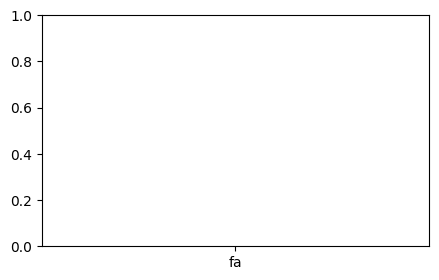

In [38]:
plt.figure(figsize=(5, 3))
plt.bar(x=['fa', 'kcat'], height=[de_fa[0], de_kcat[0], de_kcat_km[0], de_km[0]])

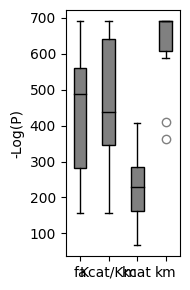

In [35]:
fig, ax = plt.subplots(figsize=(2,3))
boxplot = ax.boxplot([de_fa, de_kcat_km, de_kcat, de_km], patch_artist=True)

# Customize the appearance of the box plot
for box in boxplot['boxes']:
    # Set the fill color to grey
    box.set(facecolor='grey', edgecolor='black')

# Set the color of the whiskers, caps, and medians
for whisker in boxplot['whiskers']:
    whisker.set(color='black')
for cap in boxplot['caps']:
    cap.set(color='black')
for median in boxplot['medians']:
    median.set(color='black')

# Optional: Customize the appearance of fliers (outliers)
for flier in boxplot['fliers']:
    flier.set(marker='o', color='black', alpha=0.5)

# Set labels if needed
ax.set_xticklabels(['fa', 'Kcat/Km', 'kcat', 'km'])
ax.set_ylabel('-Log(P)')
plt.tight_layout()
plt.savefig('figures/Figure_5/de_prop_boxplot.pdf')

